<a href="https://colab.research.google.com/github/cheul0518/Self-projects/blob/main/ImageSegmentation/Unet/Sandstone(Multiclass_segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Download the dataset of sandstone
!gdown 1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU
!unzip ./sandstone_data_for_ML.zip -d ./ &> /dev/null && rm ./sandstone_data_for_ML.zip

Downloading...
From: https://drive.google.com/uc?id=1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU
To: /content/sandstone_data_for_ML.zip
100% 450M/450M [00:01<00:00, 334MB/s]


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# Unet
def uNet(n_classes=4, height=128, width=128, channels=1):
    inputs = Input((height, width, channels))

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
  
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [3]:
import tifffile
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.metrics import MeanIoU
from sklearn.preprocessing import LabelEncoder

HEIGHT = 128
WIDTH = 128
CHANNELS = 1
n_classes = 4

PATH = '/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/'
PATH_IMG = '/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images/'
PATH_MASK = '/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks/'

images = tifffile.imread(PATH + 'images_as_128x128_patches.tif')
masks = tifffile.imread(PATH + 'masks_as_128x128_patches.tif')

# Create directories if not exist
try:
    os.mkdir(os.path.join(PATH,'images/'))
    os.mkdir(os.path.join(PATH,'masks/'))
except:
    pass

# Split image & mask stacks into corresponding directories 
for i, (img, msk) in enumerate(zip(images, masks)):
    tifffile.imwrite(os.path.join(PATH, f'images/image{i}.tif'), img, photometric='minisblack')
    tifffile.imwrite(os.path.join(PATH, f'masks/mask{i}.tif'), msk, photometric='minisblack')

# Image list - > nparray
images = []
for path in sorted(glob.glob(os.path.join(PATH_IMG, '*.tif'))):
    img = cv2.imread(path, 0)
    images.append(img)
images = np.array(images)

# Mask list - > nparray
masks =[]
for path in sorted(glob.glob(os.path.join(PATH_MASK, '*.tif'))):
    mask = cv2.imread(path, 0)
    masks.append(mask)
masks = np.array(masks)

# Mask values from [1, 2, 3, 4] to [0, 1, 2, 3] for convenience
masks_encoded = masks - 1 # np.unique(masks) = [1,2,3,4] so it subtracts 1 for [0,1,2,3]

images = np.expand_dims(images, axis=3) # For images, (1600, 128, 128) -> (1600, 128, 128, 1)
images = normalize(images, axis=1) # Along axis 1 because you have to normalize per image, not per whole image (axis=0)

masks_encoded = np.expand_dims(masks_encoded, axis=3) # For masks, (1600, 128, 128) -> (1600, 128, 128, 1)

X_train, X_test, y_train, y_test = train_test_split(images, masks_encoded, test_size = 0.1, random_state= 7)

# A numpy array / a vector which has integers that represent different categories, can be converted into a numpy array / a matrix which has binary values and has columns equal to the number of categories in the data
y_train_cat = to_categorical(y_train, num_classes=n_classes) 
y_test_cat = to_categorical(y_test, num_classes=n_classes)

# Class weight calculation
# class_weights = class_weight.compute_class_weight(class_weight = "balanced", 
#                                                   classes = np.unique(masks), 
#                                                   y = masks.flatten())
# class_weights = dict(zip(np.unique(masks), class_weights))

<tifffile.TiffPage 0 @8> imagej_metadata failed with ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
<tifffile.TiffPage 0 @8> imagej_metadata failed with ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


In [4]:
model = uNet(n_classes=n_classes, height=HEIGHT, width=WIDTH, channels=CHANNELS)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=n_classes)]) # MeanIoU doesn't work properly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [5]:
hist = model.fit(X_train, 
                 y_train_cat, 
                 batch_size=16, 
                 verbose=1, 
                 epochs=50, 
                 validation_data=(X_test, y_test_cat), 
                 #class_weight=class_weights,
                 shuffle=True)

Epoch 1/50
90/90 [==============================] - 16s 38ms/step - loss: 0.8041 - accuracy: 0.7563 - mean_io_u: 0.3751 - val_loss: 0.4682 - val_accuracy: 0.8737 - val_mean_io_u: 0.3750
Epoch 2/50
90/90 [==============================] - 3s 32ms/step - loss: 0.4085 - accuracy: 0.8756 - mean_io_u: 0.3750 - val_loss: 0.3563 - val_accuracy: 0.8832 - val_mean_io_u: 0.3750
Epoch 3/50
90/90 [==============================] - 3s 32ms/step - loss: 0.3164 - accuracy: 0.8870 - mean_io_u: 0.3750 - val_loss: 0.2846 - val_accuracy: 0.8995 - val_mean_io_u: 0.3750
Epoch 4/50
90/90 [==============================] - 3s 33ms/step - loss: 0.2957 - accuracy: 0.8940 - mean_io_u: 0.3750 - val_loss: 0.2901 - val_accuracy: 0.8983 - val_mean_io_u: 0.3750
Epoch 5/50
90/90 [==============================] - 3s 33ms/step - loss: 0.2803 - accuracy: 0.9005 - mean_io_u: 0.3750 - val_loss: 0.2864 - val_accuracy: 0.8973 - val_mean_io_u: 0.3750
Epoch 6/50
90/90 [==============================] - 3s 32ms/step - loss: 0

In [6]:
model.save('test.hdf5')

_, acc, _ = model.evaluate(X_test, y_test_cat)
print(acc)

5/5 [==============================] - 1s 23ms/step - loss: 0.1513 - accuracy: 0.9499 - mean_io_u: 0.3770
0.9498569369316101


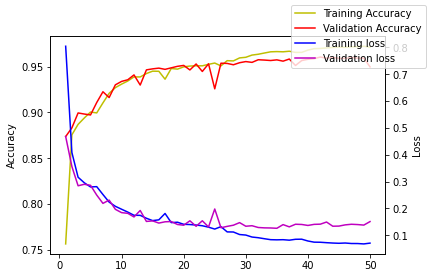

In [7]:
#model = model.load_weights('test.hdf5')

# corresponding accuracy and loss of training and validation sets
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(loss)+1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(epochs, acc, 'y', label='Training Accuracy')
ax1.plot(epochs, val_acc, 'r', label='Validation Accuracy')
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'm', label='Validation loss')

fig.legend()
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')
plt.show()

In [8]:
# Mean Intersection over Union
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=-1)

#To calculate meanIoU
mIoU = MeanIoU(num_classes = n_classes)
mIoU.update_state(y_true = y_test[:,:,:,0], y_pred = y_pred_argmax, sample_weight=None)
print(f"mIoU: {mIoU.result().numpy()}")

#To calculate I0U for each class
values = mIoU.get_weights()[0]
#print(values)
IoU_class1 = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
IoU_class2 = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
IoU_class3 = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
IoU_class4 = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print(f"IoU for class1: {IoU_class1}")
print(f"IoU for class2: {IoU_class2}")
print(f"IoU for class3: {IoU_class3}")
print(f"IoU for class4: {IoU_class4}")

mIoU: 0.8444655537605286
IoU for class1: 0.9034245610237122
IoU for class2: 0.6036496162414551
IoU for class3: 0.946344792842865
IoU for class4: 0.9244433641433716


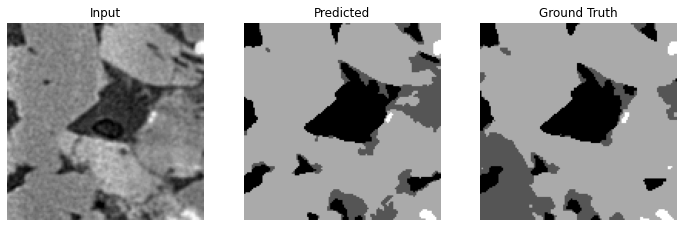

In [12]:
# Print image, predicted mask, and its ground truth mask
randN = random.randint(0, len(X_test)) # Random Number
img = X_test[randN] # (128, 128, 1)
ground_truth = y_test[randN] # (128, 128, 1)
img_inp = np.expand_dims(img, 0) # (1, 128, 128, 1)
pred = np.argmax(model.predict(img_inp), axis=3)[0,:,:] # Without [0,:,:], (1, 128, 128)

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.axis('off') 
plt.title('Input')
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(232)
plt.axis('off')
plt.title('Predicted')
plt.imshow(pred, cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.show()

In [10]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


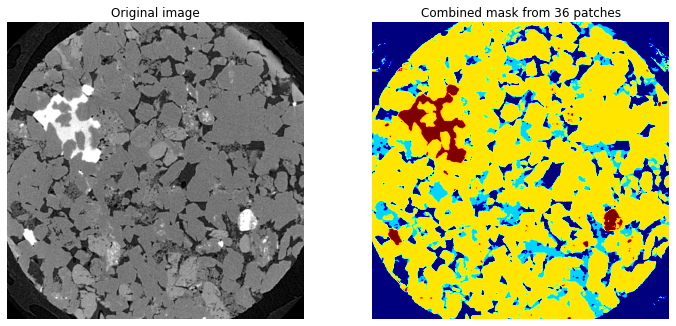

In [15]:
from patchify import patchify, unpatchify

large_image = cv2.imread('/content/sandstone_data_for_ML/full_labels_for_deep_learning/train_imgs_cropped_768.tif',0)

# large image (768, 768) -> (6,6, 128,128) of patches
patches = patchify(image=large_image, patch_size=(128, 128), step=128) # no overlap
patches_pred = []

# Compute corresponding mask to patch
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
      patch = patches[i, j, :, :]
      patch = np.expand_dims(normalize(np.array(patch), axis=0),axis=-1)
      patch = np.expand_dims(patch, axis=0)
      patch_pred = model.predict(patch)
      patch_pred = np.argmax(patch_pred, axis=-1)[0,:,:]
      patches_pred.append(patch_pred)

patches_pred = np.array(patches_pred)

patches_pred_reshaped = np.reshape(patches_pred, (6,6,128,128))
reconstructed_img = unpatchify(patches_pred_reshaped, large_image.shape)
#plt.imshow(reconstructed_img, cmap='gray')
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.axis('off')
plt.title('Original image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.axis('off')
plt.title('Combined mask from 36 patches')
plt.imshow(reconstructed_img, cmap='jet')
plt.show()
